In [1]:
import io
import re
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asemenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
trump_df = pd.read_csv('data/trump_tweets.csv', dtype={'id': np.int64}, index_col='id')
trump_df['datetime'] = pd.to_datetime(trump_df['datetime'])
trump_df['date'] = pd.to_datetime(trump_df['date'])
trump_df = trump_df.query("date >= '2019-01-01' and date < '2022-01-01'")
trump_df.head()

,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date
id,,,,,,,,,
1234653427789070336,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03 01:34:50+00:00,False,2020-03-03
1218010753434820608,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17 03:22:47+00:00,False,2020-01-17
1304875170860015616,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,2020-09-12 20:10:58+00:00,False,2020-09-12
1218159531554897920,RT @MZHemingway: Very friendly telling of even...,True,False,Twitter for iPhone,0,9081,2020-01-17 13:13:59+00:00,False,2020-01-17
1217962723234983936,RT @WhiteHouse: President @realDonaldTrump ann...,True,False,Twitter for iPhone,0,25048,2020-01-17 00:11:56+00:00,False,2020-01-17


In [5]:
def text_preprocessor(v: str) -> str:
    v = v.lower()
    v = re.sub(r'@[^\s]+', '', v)
    v = re.sub(r'https?://[^\s]+', '', v)
    v = re.sub(r'&\w+;', '', v)
    v = re.sub('\W+', ' ', v)
    v = v.strip()
    return v

In [6]:
empty_tweets = (
    trump_df.text
    .apply(text_preprocessor)
    .apply(lambda v: ' '.join(word for word in v.split() if word not in stop_words))
    .apply(lambda v: not not re.fullmatch('\W*', v))
)
print(trump_df[empty_tweets].shape)
trump_df[empty_tweets]

(1561, 9)


,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date
id,,,,,,,,,
1319501865625784320,https://t.co/4qwCKQOiOw,False,False,Twitter for iPhone,130822,19127,2020-10-23 04:52:14+00:00,False,2020-10-23
1319500520126664704,https://t.co/VlEu8yyovv,False,False,Twitter for iPhone,153446,20275,2020-10-23 04:46:53+00:00,False,2020-10-23
1319500501269041152,https://t.co/z5CRqHO8vg,False,False,Twitter for iPhone,102150,14815,2020-10-23 04:46:49+00:00,False,2020-10-23
1319500486370877440,https://t.co/TQCQiDrVOB,False,False,Twitter for iPhone,255804,35594,2020-10-23 04:46:45+00:00,False,2020-10-23
1319496349092511488,RT @EricTrump: https://t.co/NcrNdOSfIV,True,False,Twitter for iPhone,0,8921,2020-10-23 04:30:19+00:00,False,2020-10-23
...,...,...,...,...,...,...,...,...,...
1082823394234716160,https://t.co/Ft6FqQmYfI,False,False,Twitter for iPhone,128589,31456,2019-01-09 02:16:29+00:00,False,2019-01-09
1080923073820282752,https://t.co/jsOrDtwdEa,False,False,Twitter Media Studio,104658,34605,2019-01-03 20:25:18+00:00,False,2019-01-03
1080858959404240768,https://t.co/JzfXMAPwKP,False,False,Twitter for iPhone,174438,43163,2019-01-03 16:10:31+00:00,False,2019-01-03


In [7]:
trump_df = trump_df[~empty_tweets]
trump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18649 entries, 1234653427789070336 to 1319345719829008384
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   text        18649 non-null  object             
 1   is_retweet  18649 non-null  bool               
 2   is_deleted  18649 non-null  bool               
 3   device      18649 non-null  object             
 4   favorites   18649 non-null  int64              
 5   retweets    18649 non-null  int64              
 6   datetime    18649 non-null  datetime64[ns, UTC]
 7   is_flagged  18649 non-null  bool               
 8   date        18649 non-null  datetime64[ns]     
dtypes: bool(3), datetime64[ns, UTC](1), datetime64[ns](1), int64(2), object(2)
memory usage: 1.0+ MB


In [8]:
tweet_words = set()
trump_df.text.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v not in set(stop_words)]).apply(tweet_words.update)
len(tweet_words)

17529

In [9]:
def load_vectors(fname, words: set):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin, total=n):
        tokens = line.rstrip().split(' ')
        word = tokens[0].lower()
        if word in words:
            data[word] = np.array([*map(float, tokens[1:])])
    return data

In [10]:
word_embeddings = load_vectors('wiki-news-300d-1M.vec', tweet_words)

100%|█████████████████████████████████████████████████████████| 999994/999994 [00:14<00:00, 69438.05it/s]


In [11]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    # ngram_range=(1, 2),
    # max_features=1000,
    preprocessor=text_preprocessor
)
tfidf_vectorizer.fit(trump_df.text)
len(tfidf_vectorizer.vocabulary_)

17469

In [12]:
def tfidf_dict(text: str) -> dict:
    return {
        tfidf_vectorizer.get_feature_names_out()[i]: tfidf_v
        for (_, i), tfidf_v in (
            tfidf_vectorizer
            .transform([text])
            .todok()
            .items()
        )
    }

In [18]:
tfidf_dict('republicans thanks a lot')

{'lot': 0.6197629539433842,
 'republicans': 0.5076745046775218,
 'thanks': 0.5984651019230807}

In [19]:
def tweet_embedding(text: str) -> np.array:
    embedding = np.zeros(300)
    tfidf = 0
    
    text = text_preprocessor(text)
    words_tfidf = tfidf_dict(text)
    
    for word in text.split(' '):
        if word in word_embeddings and word in words_tfidf:
            word_tfidf = words_tfidf[word]
            tfidf += word_tfidf
            embedding += word_tfidf * word_embeddings[word]
    
    if tfidf:
        embedding /= tfidf
    
    return embedding

In [20]:
tweet_embedding('republicans thanks a lot')[:10]

array([-0.09323672,  0.00191374, -0.06018533,  0.06311652, -0.02387718,
       -0.06777286,  0.01590611,  0.0191122 , -0.03836583,  0.03177519])

In [21]:
text_embeddings = list()


for text in tqdm(trump_df.text.values):
    text_embeddings.append(tweet_embedding(text))

text_embeddings = np.stack(text_embeddings)
text_embeddings.shape

100%|██████████████████████████████████████████████████████████████| 18649/18649 [25:16<00:00, 12.30it/s]


(18649, 300)

In [22]:
%%time
pca = PCA(n_components=2, random_state=42)
text_pca = pca.fit_transform(text_embeddings)
print('PCA done!')

umap = UMAP(n_components=2, n_jobs=-1, random_state=42)
text_umap = umap.fit_transform(text_embeddings)
print('UMAP done!')

umap_cosine = UMAP(n_components=2, n_jobs=-1, metric='cosine', random_state=42)
text_umap_cosine = umap_cosine.fit_transform(text_embeddings)
print('UMAP(cosine) done!')

PCA done!
UMAP done!
UMAP(cosine) done!
CPU times: user 1min 19s, sys: 14 s, total: 1min 33s
Wall time: 51.8 s


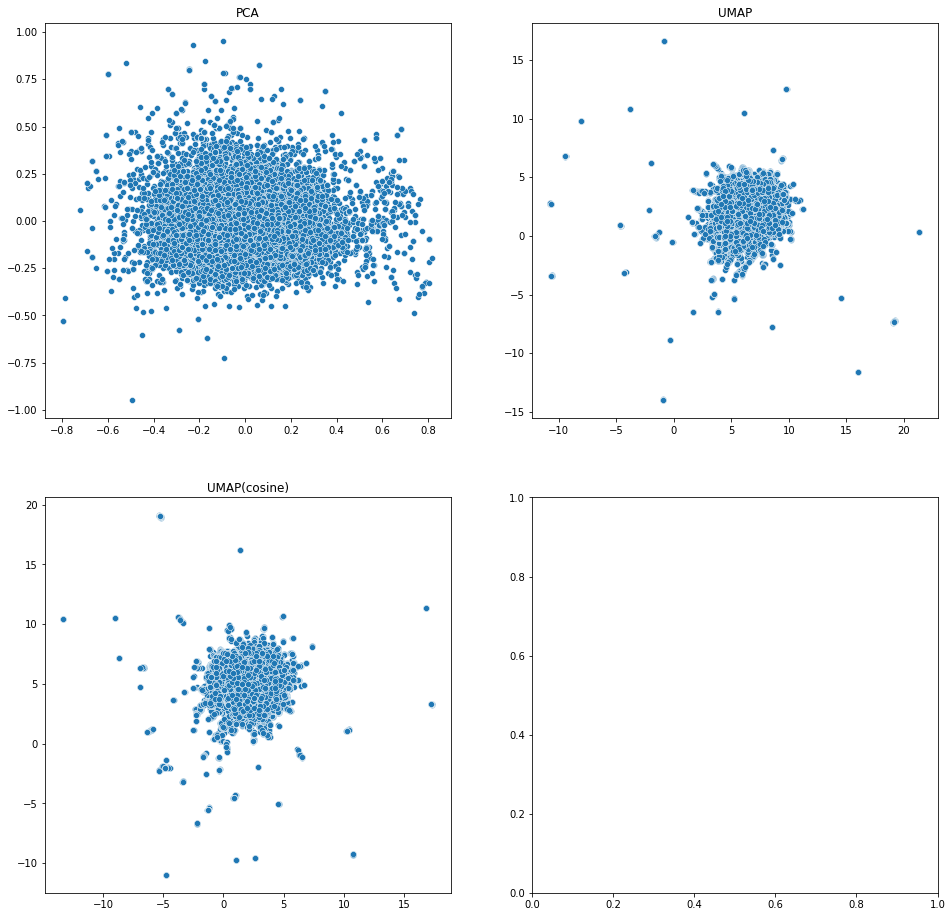

In [23]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21);

In [24]:
K = list(range(1, 16))

inertia = {}
silhouette = {}

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(text_embeddings)
    inertia[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(text_embeddings, kmeans.labels_) if k > 1 else None

100%|████████████████████████████████████████████████████████████████████| 15/15 [02:54<00:00, 11.62s/it]


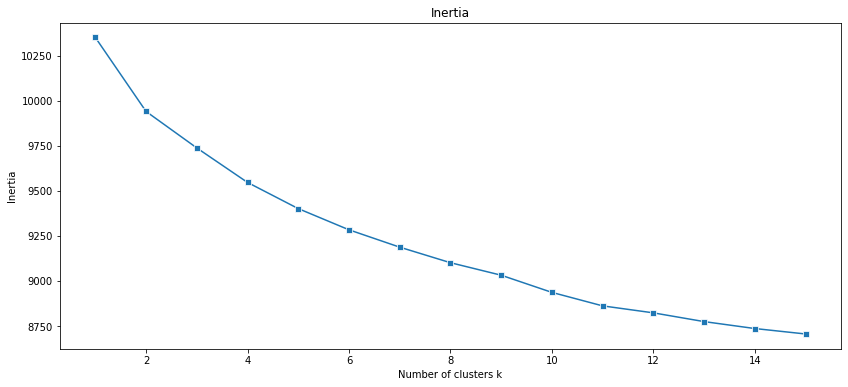

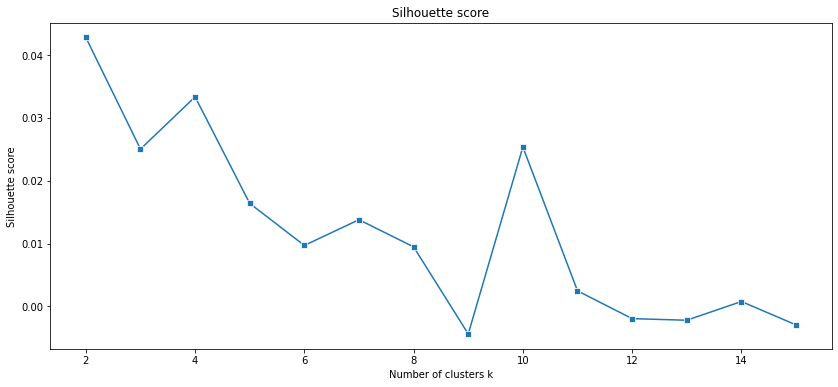

In [25]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[inertia[k] for k in K], marker='s')

plt.title('Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [26]:
d = {}
for k in K[1:-1]:
    d[k] = (inertia[k] - inertia[k + 1]) / (inertia[k - 1] - inertia[k])

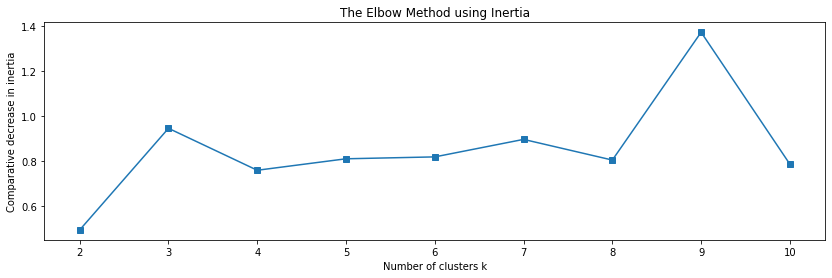

In [27]:
plt.figure(figsize=(14, 4))
plt.plot(list(d.keys())[:9], list(d.values())[:9], marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

In [32]:
kmeans = KMeans(
    n_clusters=2,
    # eps=0.6,
    # metric='cosine',
    random_state=42
)
clusters = kmeans.fit_predict(text_embeddings)
# clusters = kmeans.fit_predict(text_pca)
print(len(set(clusters)))

2


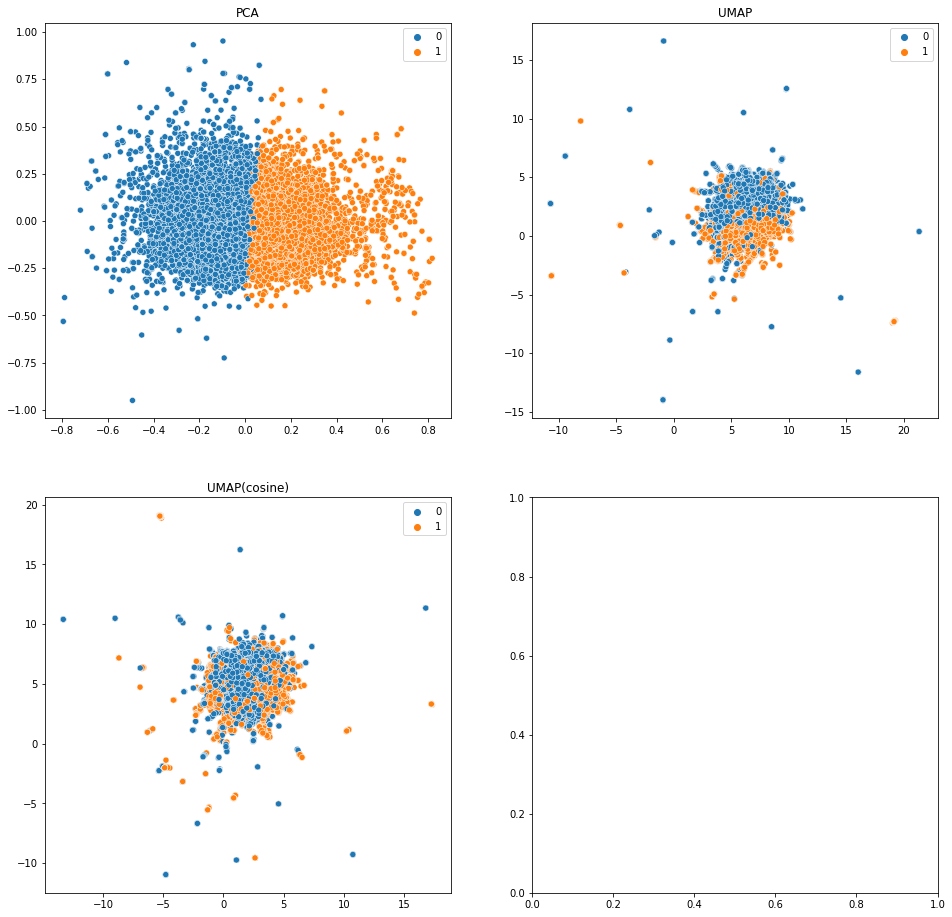

In [33]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=clusters);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=clusters);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=clusters);

In [34]:
def print_top_n_words(data: pd.Series, n: int = 25):
    words_counter = collections.Counter()
    data.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v in word_embeddings]).apply(words_counter.update)
    return words_counter.most_common(n)

In [35]:
trump_df['cluster'] = clusters
trump_df.groupby('cluster')['cluster'].count()

cluster
0    11046
1     7603
Name: cluster, dtype: int64

In [36]:
for cluster in set(trump_df['cluster']):
    print(
        f'Cluster {cluster:3}. {len(trump_df.query(f"cluster == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(trump_df.query(f'cluster == {cluster}').text, n=3)
    )

Cluster   0. 11046 tweets total. Top-3 words: [('great', 1888), ('president', 1255), ('people', 1107)]
Cluster   1.  7603 tweets total. Top-3 words: [('president', 1165), ('trump', 846), ('thank', 753)]


In [38]:
cluster = 1

print(print_top_n_words(trump_df.query(f'cluster == {cluster}').text))
trump_df.query(f'cluster == {cluster}').head(10)

[('president', 1165), ('trump', 846), ('thank', 753), ('amp', 665), ('news', 593), ('great', 589), ('democrats', 549), ('new', 485), ('people', 426), ('would', 413), ('fake', 393), ('media', 348), ('biden', 348), ('big', 330), ('house', 328), ('even', 323), ('like', 315), ('american', 303), ('china', 303), ('never', 301), ('nothing', 295), ('time', 288), ('america', 285), ('one', 283), ('impeachment', 260)]


,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date,cluster
id,,,,,,,,,,
1234653427789070336,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03 01:34:50+00:00,False,2020-03-03,1
1218010753434820608,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17 03:22:47+00:00,False,2020-01-17,1
1218159531554897920,RT @MZHemingway: Very friendly telling of even...,True,False,Twitter for iPhone,0,9081,2020-01-17 13:13:59+00:00,False,2020-01-17,1
1225835449379258368,RT @TomFitton: Vindman's behavior is a scandal...,True,False,Twitter for iPhone,0,7679,2020-02-07 17:35:20+00:00,False,2020-02-07,1
1215247978966986752,Thank you Elise! https://t.co/Y4Hb0zf5jk,False,False,Twitter for iPhone,48510,11608,2020-01-09 12:24:31+00:00,False,2020-01-09,1
1319491234042269696,"As per your request, Joe... https://t.co/78mzc...",False,False,Twitter for iPhone,253761,79855,2020-10-23 04:09:59+00:00,False,2020-10-23,1
1319488376202878976,RT @marklevinshow: President Trump was outstan...,True,False,Twitter for iPhone,0,21259,2020-10-23 03:58:38+00:00,False,2020-10-23,1
1325884977112883200,The threshold identification of Ballots is tur...,False,False,Twitter for iPhone,493076,100609,2020-11-09 19:36:26+00:00,False,2020-11-09,1
1319656414437138432,RT @TheRightMelissa: I guarantee it was the 1s...,True,False,Twitter for iPhone,0,26026,2020-10-23 15:06:21+00:00,False,2020-10-23,1


In [39]:
EPS = np.linspace(0.01, 10., 100)

silhouette = {}
clusters = {}

for eps in tqdm(EPS):
    dbscan = DBSCAN(eps=eps, n_jobs=-1).fit(text_embeddings) # metric='cosine' checked
    clusters[eps] = len(set(dbscan.labels_)) - 1
    # print(set(dbscan.labels_))
    if len(set(dbscan.labels_)) > 1:
        # print(eps, set(dbscan.labels_))
        silhouette[eps] = silhouette_score(text_embeddings, dbscan.labels_)
# print(silhouette

100%|██████████████████████████████████████████████████████████████████| 100/100 [12:20<00:00,  7.41s/it]


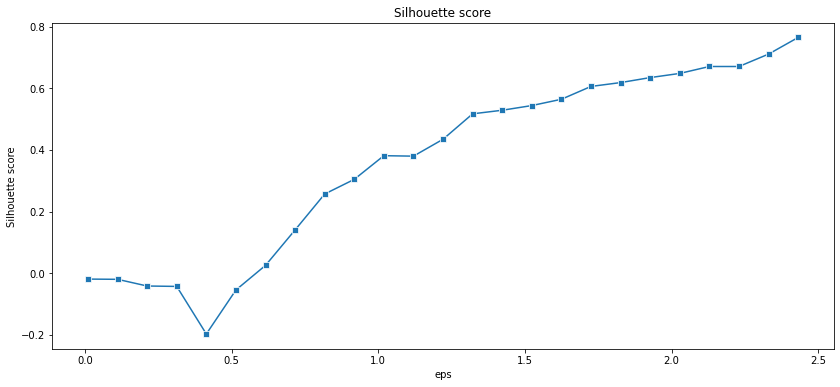

In [40]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[silhouette.get(eps) for eps in EPS], marker='s')

plt.title('Silhouette score')
plt.xlabel('eps')
plt.ylabel('Silhouette score')

plt.show()

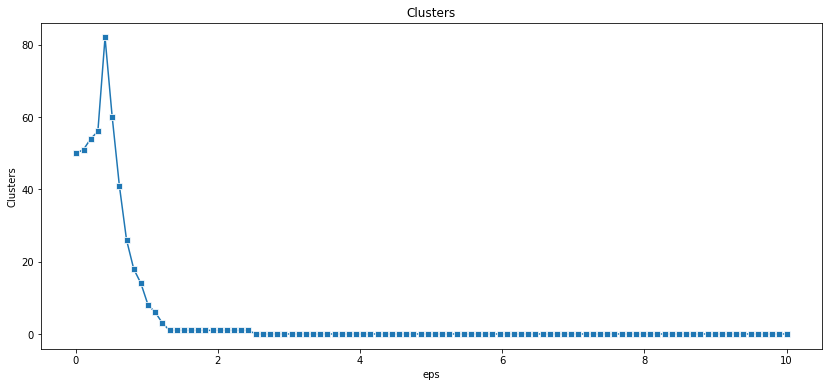

In [41]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[clusters.get(eps) for eps in EPS], marker='s')

plt.title('Clusters')
plt.xlabel('eps')
plt.ylabel('Clusters')

plt.show()

In [45]:
# best_eps = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_eps = max({eps for eps, c in clusters.items() if c == 3})
best_eps, clusters.get(best_eps)

(1.220909090909091, 3)

In [46]:
dbscan = DBSCAN(eps=best_eps, n_jobs=-1) # metric='cosine' checked
trump_df['cluster_dbscan'] = dbscan.fit_predict(text_embeddings)

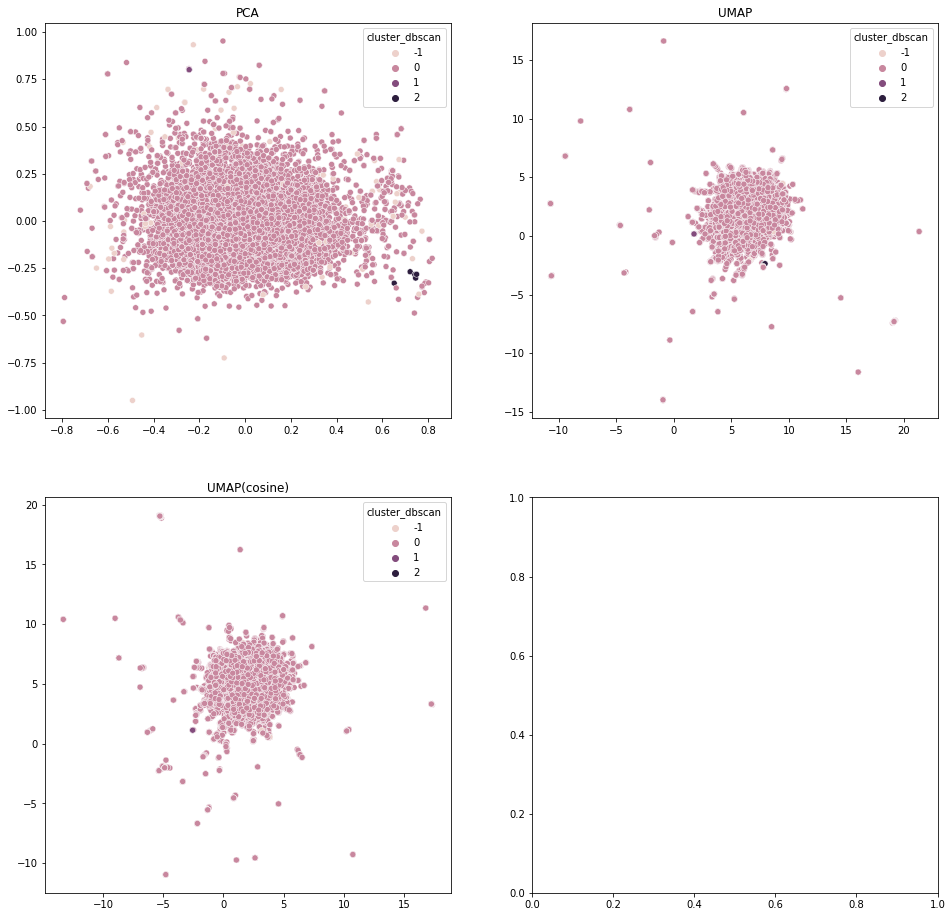

In [47]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=trump_df['cluster_dbscan']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=trump_df['cluster_dbscan']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=trump_df['cluster_dbscan']);

In [48]:
trump_df.groupby('cluster_dbscan')['cluster_dbscan'].count()

cluster_dbscan
-1      145
 0    18491
 1        8
 2        5
Name: cluster_dbscan, dtype: int64

In [49]:
for cluster in set(trump_df['cluster_dbscan']):
    print(
        f'Cluster {cluster:3}. {len(trump_df.query(f"cluster_dbscan == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(trump_df.query(f'cluster_dbscan == {cluster}').text, n=3)
    )

Cluster   0. 18491 tweets total. Top-3 words: [('great', 2473), ('president', 2419), ('trump', 1825)]
Cluster   1.     8 tweets total. Top-3 words: [('amazing', 8)]
Cluster   2.     5 tweets total. Top-3 words: [('क', 26), ('र', 13), ('ल', 11)]
Cluster  -1.   145 tweets total. Top-3 words: [('thank', 11), ('see', 4), ('great', 4)]


In [50]:
cluster = -1

print(print_top_n_words(trump_df.query(f'cluster_dbscan == {cluster}').text))
trump_df.query(f'cluster_dbscan == {cluster}').head(10)

[('thank', 11), ('see', 4), ('great', 4), ('trump', 4), ('glitch', 3), ('back', 3), ('cute', 3), ('sotu', 3), ('ari', 3), ('justice', 3), ('gt', 3), ('megyn', 2), ('amen', 2), ('says', 2), ('appeal', 2), ('7', 2), ('live', 2), ('valdosta', 2), ('bad', 2), ('thx', 2), ('thanks', 2), ('inference', 2), ('go', 2), ('enjoy', 2), ('cruises', 2)]


,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date,cluster,cluster_dbscan
id,,,,,,,,,,,
1319655865083940864,Thank you Megyn! https://t.co/sC71EEWIOd,False,False,Twitter for iPhone,178163,24864,2020-10-23 15:04:10+00:00,False,2020-10-23,1,-1
1320165221877583872,RT @dbongino: Amen to that!\nhttps://t.co/yRr4...,True,False,Twitter for iPhone,0,9281,2020-10-25 00:48:11+00:00,False,2020-10-25,1,-1
1346478482105069568,See you in D.C. https://t.co/ti4bChnPKz,False,False,Twitter for iPhone,127896,25649,2021-01-05 15:27:41+00:00,False,2021-01-05,0,-1
1326023108604661760,RT @BreitbartNews: No doubt about it. https://...,True,False,Twitter for iPhone,0,16375,2020-11-10 04:45:20+00:00,False,2020-11-10,0,-1
1326033164523933696,RT @BreitbartNews: Ouch. https://t.co/uwCChJoX2V,True,False,Twitter for iPhone,0,18808,2020-11-10 05:25:17+00:00,False,2020-11-10,1,-1
1329521771041726464,We withdrew because we won! https://t.co/aMoNQ...,False,False,Twitter for iPhone,191015,36464,2020-11-19 20:27:46+00:00,False,2020-11-19,1,-1
1320043672197619712,RT @realDonaldTrump: Thank you Megyn!,True,False,Twitter for iPhone,0,24708,2020-10-24 16:45:11+00:00,False,2020-10-24,1,-1
1328815025662914560,THIS SAYS IT ALL! https://t.co/zZSspsJPe9,False,False,Twitter for iPhone,216066,49633,2020-11-17 21:39:24+00:00,False,2020-11-17,0,-1
1320481137878208512,Thank you Rabbis! https://t.co/Lwo07ggfuc,False,False,Twitter for iPhone,67700,13923,2020-10-25 21:43:31+00:00,False,2020-10-25,1,-1


In [51]:
K = list(range(2, 50))

silhouette = {}

for k in tqdm(K):
    aggl = AgglomerativeClustering(n_clusters=k).fit(text_embeddings)
    silhouette[k] = silhouette_score(text_embeddings, aggl.labels_) if k > 1 else None

100%|████████████████████████████████████████████████████████████████████| 48/48 [47:33<00:00, 59.44s/it]


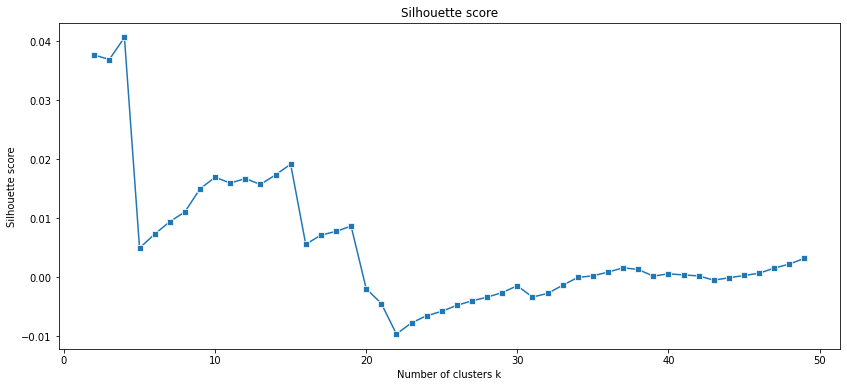

In [52]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [53]:
best_k = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_k

4

In [54]:
%%time
agglomerative = AgglomerativeClustering(n_clusters=best_k)
trump_df['cluster_agglom'] = agglomerative.fit_predict(text_embeddings)

CPU times: user 52.6 s, sys: 591 ms, total: 53.2 s
Wall time: 53 s


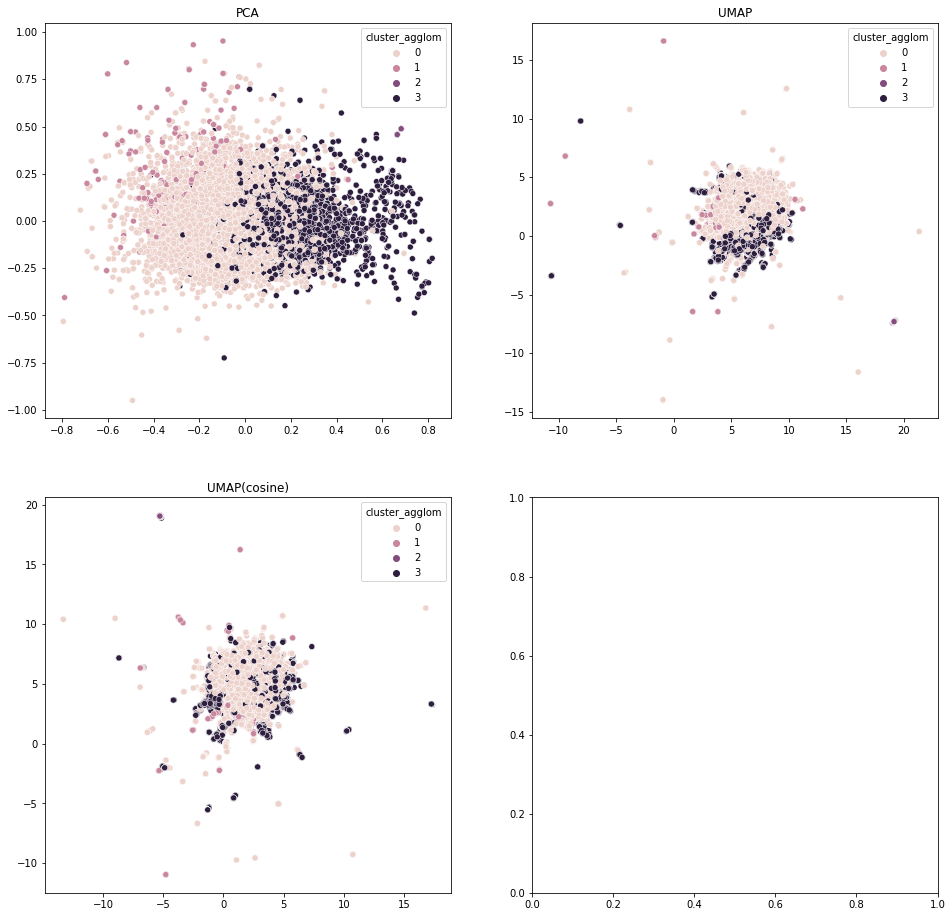

In [55]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=trump_df['cluster_agglom']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=trump_df['cluster_agglom']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=trump_df['cluster_agglom']);

In [56]:
trump_df.groupby('cluster_agglom')['cluster_agglom'].count()

cluster_agglom
0    13295
1      386
2      131
3     4837
Name: cluster_agglom, dtype: int64

In [57]:
for cluster in set(trump_df['cluster_agglom']):
    print(
        f'Cluster {cluster:3}. {len(trump_df.query(f"cluster_agglom == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(trump_df.query(f'cluster_agglom == {cluster}').text, n=3)
    )

Cluster   0. 13295 tweets total. Top-3 words: [('great', 1827), ('president', 1732), ('trump', 1307)]
Cluster   1.   386 tweets total. Top-3 words: [('great', 230), ('america', 86), ('make', 56)]
Cluster   2.   131 tweets total. Top-3 words: [('thank', 124), ('thanks', 7)]
Cluster   3.  4837 tweets total. Top-3 words: [('president', 683), ('amp', 523), ('trump', 521)]


In [65]:
cluster = 2

print('Entries:', len(trump_df.query(f'cluster_agglom == {cluster}')))
print(print_top_n_words(trump_df.query(f'cluster_agglom == {cluster}').text))
trump_df.query(f'cluster_agglom == {cluster}').head(10)#.text.apply(text_preprocessor)

Entries: 131
[('thank', 124), ('thanks', 7)]


,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date,cluster,cluster_dbscan,cluster_agglom
id,,,,,,,,,,,,
1317060388371025920,Thank you! https://t.co/ceq1n14MYa,False,False,Twitter for iPhone,41882,7722,2020-10-16 11:10:41+00:00,False,2020-10-16,1,0,2
1332055759551680512,No thanks! https://t.co/IYQSotnMG9,False,False,Twitter for iPhone,180746,26634,2020-11-26 20:16:56+00:00,False,2020-11-26,1,0,2
1330487624402935808,Thank you! https://t.co/xe4WZt1wNe,False,False,Twitter for iPhone,128431,26105,2020-11-22 12:25:43+00:00,False,2020-11-22,1,0,2
1317044734989402112,Thank you! https://t.co/XIEd0dSEvA,False,False,Twitter for iPhone,60088,11977,2020-10-16 10:08:28+00:00,False,2020-10-16,1,0,2
1268871820884803584,"RT @SenRonJohnson: Thanks, @realDonaldTrump",True,False,Twitter for iPhone,0,1742,2020-06-05 11:46:31+00:00,False,2020-06-05,1,0,2
1335462968084090880,Thank you! https://t.co/X7gFdH8fqW,False,False,Twitter for iPhone,64515,10305,2020-12-06 05:55:57+00:00,False,2020-12-06,1,0,2
1328853928025403392,THANK YOU! https://t.co/DrtsiD71i4,False,False,Twitter for iPhone,142076,25533,2020-11-18 00:14:00+00:00,False,2020-11-18,1,0,2
1337062086724247552,"RT @Lancegooden: Thank you to @RepGosar, @RepA...",True,False,Twitter for iPhone,0,4536,2020-12-10 15:50:17+00:00,False,2020-12-10,1,0,2
1339758279526916096,Thank you! https://t.co/Du7bro3qis,False,False,Twitter for iPhone,98337,15722,2020-12-18 02:24:00+00:00,False,2020-12-18,1,0,2
